In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import time
import os 
import copy
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt


In [2]:
def createFolder(directory):
    try: 
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print("Error")
createFolder('./data')

In [3]:
ds_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

train_ds = datasets.MNIST('/content/data',train=True,download=True,transform=ds_transform)

val_ds = datasets.MNIST('/content/data',train=False,download=True,transform=ds_transform)

Using downloaded and verified file: /content/data\MNIST\raw\train-images-idx3-ubyte.gz
Extracting /content/data\MNIST\raw\train-images-idx3-ubyte.gz to /content/data\MNIST\raw

Using downloaded and verified file: /content/data\MNIST\raw\train-labels-idx1-ubyte.gz
Extracting /content/data\MNIST\raw\train-labels-idx1-ubyte.gz to /content/data\MNIST\raw



100.0%


Extracting /content/data\MNIST\raw\t10k-images-idx3-ubyte.gz to /content/data\MNIST\raw



112.7%

Extracting /content/data\MNIST\raw\t10k-labels-idx1-ubyte.gz to /content/data\MNIST\raw



In [4]:
train_dl = DataLoader(train_ds,batch_size=32,shuffle=True)
val_dl = DataLoader(val_ds,batch_size =32,shuffle=True)

torch.Size([32, 1, 28, 28]) torch.Size([32])


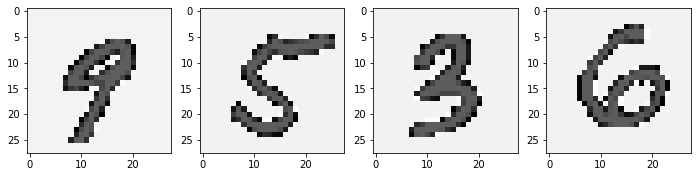

In [5]:
for x,y in train_dl:
    print(x.shape,y.shape)
    break
num=4
imgs = x[:num]
plt.figure(figsize=(15,15))
for i in range(num):
    plt.subplot(1,num+1,i+1)
    plt.imshow(to_pil_image(0.1307*imgs[i]),cmap='gray')

In [6]:
class Teacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1= nn.Linear(28*28,1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024,1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024,10)
        
    def forward(self,x):
        x = x.view(-1,784)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x
    
        

In [7]:
x = torch.randn(16,1,28,28)
teacher = Teacher()
output = teacher(x)
print(output.shape)

torch.Size([16, 10])


In [8]:
def initialize_weights(model):
    classname = model.__class__.__name__
    
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data,1.0,0.02)
        nn.init.constant_(model.bias.data,0)
    elif classname.find('BatchNorm') !=-1:
        nn.init.normal_(model.weight.data,1.0,0.02)
        nn.init.constant_(model.bias.data,0)
        
teacher.apply(initialize_weights)

Teacher(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
)

In [9]:
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(teacher.parameters())

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt,mode='min',factor=0.1,patience= 3)

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
def metric_batch(output,target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b

def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric




In [10]:
# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [11]:
params_train = {
    'num_epochs':10,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/teacher_weights.pt',
}

createFolder('./models')

In [12]:
teacher, loss_hist, metric_hist = train_val(teacher, params_train)

Epoch 0/9, current lr= 0.001
Copied best model weights!
train loss: 0.052358, val loss: 0.020611, accuracy: 79.88, time: 0.3854 min
----------
Epoch 1/9, current lr= 0.001
Copied best model weights!
train loss: 0.017786, val loss: 0.010561, accuracy: 89.56, time: 0.7666 min
----------
Epoch 2/9, current lr= 0.001
Copied best model weights!
train loss: 0.013508, val loss: 0.009237, accuracy: 91.01, time: 1.1507 min
----------
Epoch 3/9, current lr= 0.001
Copied best model weights!
train loss: 0.011618, val loss: 0.008557, accuracy: 91.40, time: 1.5322 min
----------
Epoch 4/9, current lr= 0.001
Copied best model weights!
train loss: 0.010640, val loss: 0.007323, accuracy: 92.89, time: 1.9118 min
----------
Epoch 5/9, current lr= 0.001
Copied best model weights!
train loss: 0.009630, val loss: 0.007218, accuracy: 93.36, time: 2.2967 min
----------
Epoch 6/9, current lr= 0.001
Copied best model weights!
train loss: 0.009048, val loss: 0.006492, accuracy: 93.65, time: 2.6853 min
----------

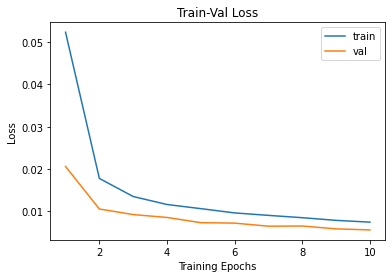

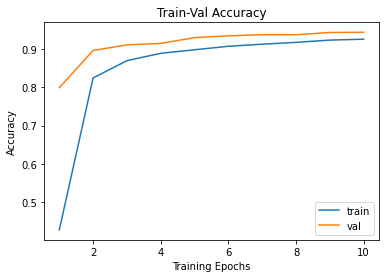

In [15]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

In [16]:
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28,512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512,512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512,10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [17]:
student = Student()
student.apply(initialize_weights);

In [19]:
teacher = Teacher()
teacher.load_state_dict(torch.load('./models/teacher_weights.pt'))

student = Student()
opt = optim.Adam(student.parameters())

In [20]:
# knowledge distillation loss
def distillation(y, labels, teacher_scores, T, alpha):
    # distillation loss + classification loss
    # y: student
    # labels: hard label
    # teacher_scores: soft label
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T*alpha) + F.cross_entropy(y,labels) * (1.-alpha)

# val loss
loss_func = nn.CrossEntropyLoss()

In [22]:
def distill_loss_batch(output, target, teacher_output, loss_fn=distillation, opt=opt):
    loss_b = loss_fn(output, target, teacher_output, T=20.0, alpha=0.7)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b

In [23]:
num_epochs= 10

loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

best_loss = float('inf')
start_time = time.time()

for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

    # train
    student.train()

    running_loss = 0.0
    running_metric = 0.0
    len_data = len(train_dl.dataset)

    for xb, yb in train_dl:
        xb = xb
        yb = yb

        output = student(xb)
        teacher_output = teacher(xb).detach()
        loss_b, metric_b = distill_loss_batch(output, yb, teacher_output, loss_fn=distillation, opt=opt)
        running_loss += loss_b
        running_metric_b = metric_b
    train_loss = running_loss / len_data
    train_metric = running_metric / len_data

    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # validation
    student.eval()
    with torch.no_grad():
        val_loss, val_metric = loss_epoch(student, loss_func, val_dl)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)


    lr_scheduler.step(val_loss)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

Epoch 0/9, current lr= 0.001


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_13064/3873489039.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T*alpha) + F.cross_entropy(y,labels) * (1.-alpha)
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_13064/3873489039.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T*alpha) + F.cross_entropy(y,labels) * (1.-alpha)
C:\ProgramData\Anaconda3\envs\torchcuda\lib\site-packages\torch\nn\functional.py:2747: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  

train loss: 0.003175, val loss: 0.003510, accuracy: 96.74, time: 0.2747 min
----------
Epoch 1/9, current lr= 0.001
train loss: 0.001966, val loss: 0.002952, accuracy: 97.28, time: 0.5517 min
----------
Epoch 2/9, current lr= 0.001
train loss: 0.001726, val loss: 0.002918, accuracy: 97.35, time: 0.8299 min
----------
Epoch 3/9, current lr= 0.001
train loss: 0.001561, val loss: 0.002700, accuracy: 97.54, time: 1.1024 min
----------
Epoch 4/9, current lr= 0.001
train loss: 0.001418, val loss: 0.002618, accuracy: 97.59, time: 1.3757 min
----------
Epoch 5/9, current lr= 0.001
train loss: 0.001321, val loss: 0.002383, accuracy: 97.88, time: 1.6496 min
----------
Epoch 6/9, current lr= 0.001
train loss: 0.001218, val loss: 0.002374, accuracy: 97.86, time: 1.9309 min
----------
Epoch 7/9, current lr= 0.001
train loss: 0.001154, val loss: 0.002237, accuracy: 97.89, time: 2.2081 min
----------
Epoch 8/9, current lr= 0.001
train loss: 0.001120, val loss: 0.002223, accuracy: 98.06, time: 2.4856 

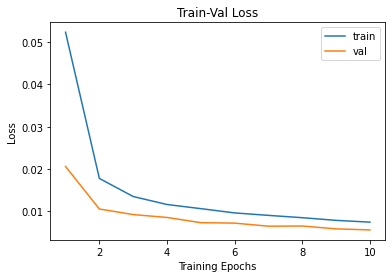

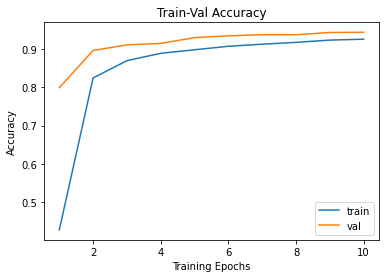

In [24]:
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()